# Is Fandango Still Inflating Ratings?

   In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in this [article](https://fivethirtyeight.com/features/fandango-movies-ratings/).
In a nutshell, the problem is that the actual rating (given by users) was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

# Exploring the Datasets

One of the best ways to figure out whether there has been any change in Fandango's rating system after Hickey's analysis is to compare the system's characteristics previous and after the analysis.

- Walt Hickey made the data he analyzed publicly available [on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango).
- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

On the links above, we can check out both data dictionaries.

Let's explore briefly them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [2]:
movies_before = pd.read_csv('fandango_score_comparison.csv')
movies_before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [3]:
movies_after = pd.read_csv('movie_ratings_16_17.csv')
movies_after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


Let's isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily avaiable for later use.

In [4]:
f_before = movies_before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue',
                          'Fandango_votes', 'Fandango_Difference']]
f_after = movies_after[['movie', 'year', 'fandango']]

Since our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our population of interest is the movie ratings of all movies available on Fandango's website.

According to Hickey's article and checking his [https://github.com/fivethirtyeight/data/blob/master/fandango/fandango_scrape.csv](GitHub Repository), when he scraped the data, he pulled data for 510 films on Fandango.com that had tickets on sale in 2015.
However, the data he used to do the analysis was sampled conforming the following criteria: "every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango."

Furthermore, the Dataquest sampled the movies using this criteria: "(...) 214 of the most popular movies (with a significant number of votes) released in 2016 and 2017". They are also considering the other sites as well.

Based on these informations, we can conclude that the sampling is not random: the movies don't have an equal chance to be included in the two samples. Also, the resulting samples are very unlikely to be representative of the population we're interested in describing.

# Slightly Changing Our Goal

Since it's quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time, we'll slightly change our goal. Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

# Isolating the Samples We Need

With this new research goal, we have two populations of interest:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

Now, we need to be clear about what is popularity. For the first sample, Hickey considered only movies with 30 or more fan ratings. However, in the second sample, it was defined as "significant number of votes". We need to be skeptical once more and see whether this sample is representative and contains popular movies (> 30 fan reviews).

A quick way to check whether the second sample contains enough popular movies as to be representative is randomly pick 10 movies from this dataset and check manually on Fandango's website.

In [5]:
f_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


It looks like Fandango's website doesn't have their own rating system anymore. However, they are using the RottenTomatoes one. This way, we can check for the number of ratings on this website for each movie in the sample above.

As of May 2021, these are the fan ratings we found:

In [6]:
movies = []
for row in f_after['movie'].sample(10, random_state=1):
    movies.append(row)
Rot_Tom_Ratings = ['25,000+', '25,000+', '5,000+', '25,000+', '50,000+',
                   '2,500+', '2,500+', '25,000+', '10,000+', '100,000+']
rotten_tom_ratings = pd.Series(data=Rot_Tom_Ratings, index=movies)
rotten_tom_ratings

Mechanic: Resurrection                      25,000+
Warcraft                                    25,000+
Max Steel                                    5,000+
Me Before You                               25,000+
Fantastic Beasts and Where to Find Them     50,000+
Cell                                         2,500+
Genius                                       2,500+
Sully                                       25,000+
A Hologram for the King                     10,000+
Captain America: Civil War                 100,000+
dtype: object

All movies in our sample is popular. It gives us a bit more confidence to consider our second sample as representative.

Let's also double-check the other data set for popular movies. The documentation states clearly that there're only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [7]:
f_before[f_before['Fandango_votes'] < 30].count()

FILM                    0
Fandango_Stars          0
Fandango_Ratingvalue    0
Fandango_votes          0
Fandango_Difference     0
dtype: int64

So, it does have only movies with as least 30 fan ratings.

Now, let's check if the first sample has only movies released in 2015 and the second one, movies released in 2016.
- For the first sample, we'll check if there is any movie from 2013 or 2014 and drop it from our dataset.
- Same idea we'll be applied to the second, but for other years different from 2016.

In [8]:
mask_1 = f_before['FILM'].str.contains(r'\b(201[3-4])')
f_2015 = f_before.drop(f_before[mask_1].index)
print(f_2015.head(10))
print(f_2015.shape)

                                 FILM  Fandango_Stars  Fandango_Ratingvalue  \
0      Avengers: Age of Ultron (2015)             5.0                   4.5   
1                   Cinderella (2015)             5.0                   4.5   
2                      Ant-Man (2015)             5.0                   4.5   
3              Do You Believe? (2015)             5.0                   4.5   
4       Hot Tub Time Machine 2 (2015)             3.5                   3.0   
5            The Water Diviner (2015)             4.5                   4.0   
6               Irrational Man (2015)             4.0                   3.5   
8        Shaun the Sheep Movie (2015)             4.5                   4.0   
9                 Love & Mercy (2015)             4.5                   4.0   
10  Far From The Madding Crowd (2015)             4.5                   4.0   

    Fandango_votes  Fandango_Difference  
0            14846                  0.5  
1            12640                  0.5  
2   

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [9]:
f_2016 = f_after[f_after['year'] == 2016]
f_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

# Comparing Distributions Shapes

Again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and the 2016 ones.
Let's start making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

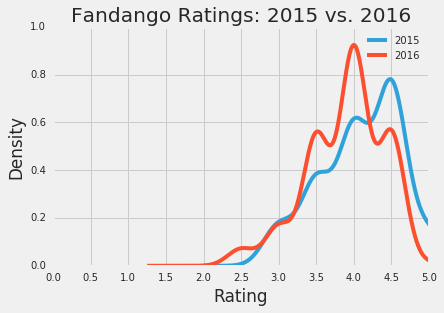

In [10]:
plt.style.use('fivethirtyeight')
f_2015['Fandango_Stars'].plot.kde(label='2015', legend=True)
f_2016['fandango'].plot.kde(label='2016', legend=True)
plt.title("Fandango Ratings: 2015 vs. 2016")
plt.xlabel('Rating')
plt.xlim(0,5)
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.show()

Analyzing the shapes of each distribution, both are left skewed, i.e. their bodies are on the right side and the tail on the left, but the 2015 shape stands out about skewness. We can see that the peak of the shape shifted: whereas the 2015 one peaked at 4.5 of rating, the 2016 shaped did it at 4.0. We can clearly see the 2016 distribution is not an "ascending" shape anymore and its values decreased. For instance, the densities of movies with 3.5 and 4.5 are equal, unlike the previous year, where 4.5 rating is double of the 3.5 rating frequency.

Overall, we can tell the movies in 2016 rated lower compared to 2015. However, to statistically confirm it we have to do a hypothesis test, but it's not in the scope of this project.

# Comparing Relative Frequencies

Let's analyze more granular information by comparing both relative frequencies tables. Doesn't make sense to us to compare the two tables using absolute frequencies, since the first sample has 129 movies, whereas the second one has 191.

In [11]:
f_2015['Fandango_Stars'].value_counts(normalize=True).sort_index() * 100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [12]:
f_2016['fandango'].value_counts(normalize=True).sort_index() * 100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

Analyzing both tables, we can clearly see that the distribution shifted to lower values. In 2015, roughly 7% of ratings are 5.0 stars; the 4.5 and 5.0 frequencies sums up approximately 45%, almost half of the sample and there is no value under 3.0 stars.

Meanwhile, in 2016 there is a clear high ratings (4.5 and 5.0) percentual decrease. The 5.0 rating dropped down to 0.5%, value almost fourteen times lower than in 2015. The higher frequencies of the 3.5 and 4.0 ratings could be explained by the previous mentioned decrease. We also can see now the presence of the 2.5 of rating, previously non-existent.

We can confirm with these two tables that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

# Determining the Direction of the Change

We'll compute statistics metrics, in this case, mean, median and mode, for each distribution and compare them in order to determine what they tell about the direction of the difference.

In [13]:
fandango_2015_mean = f_2015["Fandango_Stars"].mean()
fandango_2015_median = f_2015["Fandango_Stars"].median()
fandango_2015_mode = f_2015["Fandango_Stars"].mode()[0]

fandango_2016_mean = f_2016["fandango"].mean()
fandango_2016_median = f_2016["fandango"].median()
fandango_2016_mode = f_2016["fandango"].mode()[0]

summary_stat = pd.DataFrame({"mean": [fandango_2015_mean, fandango_2016_mean], 
                             "median":[fandango_2015_median, fandango_2016_median],
                             "mode": [fandango_2015_mode, fandango_2016_mode]}, index=['2015', '2016']).T
summary_stat

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


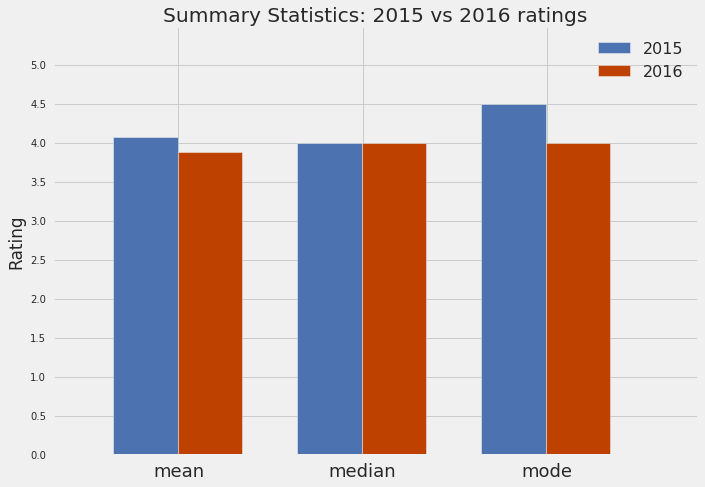

In [14]:
labels = summary_stat.index.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, summary_stat['2015'], width, label='2015')
rects2 = ax.bar(x + width/2, summary_stat['2016'], width, label='2016', color=(190/255, 65/255, 0))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rating')
ax.set_title('Summary Statistics: 2015 vs 2016 ratings')
ax.set_ylim(0,5.5)
ax.set_yticks(np.arange(0,5.1,0.5))
ax.set_xticks(x+0.18)
ax.set_xticklabels(labels, fontsize=18)
ax.legend(fontsize=16)

fig.tight_layout()

plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [15]:
(summary_stat['2015'][0] - summary_stat['2016'][0]) / summary_stat['2015'][0]

0.04842683568951993

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

# Conclusion
Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.